<a href="https://colab.research.google.com/github/MDankloff/ClusterCompas/blob/main/V3_COMPAS_Clustering_K_Means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import os
from sklearn.cluster import KMeans, DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MeanShift, estimate_bandwidth
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy import stats
from scipy.stats import ttest_ind
from scipy.stats import f_oneway

import warnings
warnings.filterwarnings('ignore')

# LOAD (META) DATA

In [4]:
data_shaper = pd.read_csv('/content/Compas_error_shap.csv')
#data_shaperr.head()
#data_shaperr.info()
#data_shaper.iloc[3]

In [5]:
#Master Dataset
META_COL = ['clusters', 'new_clusters']
META_COL_VIZ = ['Error_Type']

ERROR_COL = ['errors', 'TP', 'TN', 'FN', 'FP']
BASIC_COL = ['age', 'decile_score', 'priors_count']
DUMMY_COL = ['sex_Female','race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic',
                      'race_Native American', 'race_Other']

ERROR_COL_scaled = ['errors_scaled', 'TP_scaled', 'TN_scaled', 'FN_scaled', 'FP_scaled']
BASIC_COL_scaled = ['age_scaled', 'decile_score_scaled', 'priors_count_scaled']
DUMMY_COL_scaled = ['sex_Female_scaled', 'race_Native American_scaled','race_Other_scaled',
                'race_African-American_scaled', 'race_Asian_scaled', 'race_Caucasian_scaled', 'race_Hispanic_scaled']

#SHAP is created on BASIC_COL_scaled and DUMMY_COL_scaled
SHAP_BASIC = ['Shap_age', 'Shap_decile_score', 'Shap_priors_count']
SHAP_DUMMY = ['Shap_sex_Female','Shap_race_African-American', 'Shap_race_Asian', 'Shap_race_Caucasian',
                         'Shap_race_Hispanic', 'Shap_race_Native American', 'Shap_race_Other']

SHAP_BASIC_scaled = ['Shap_age_scaled', 'Shap_decile_score_scaled', 'Shap_priors_count_scaled']
SHAP_DUMMY_scaled = ['Shap_sex_Female_scaled','Shap_race_African-American_scaled',
                     'Shap_race_Asian_scaled', 'Shap_race_Caucasian_scaled','Shap_race_Hispanic_scaled',
                     'Shap_race_Native American_scaled', 'Shap_race_Other_scaled']

# DATA PREP UTILS

In [6]:
#Seperate TPFN & TNFP dataset
'''Drop rows where both TP and FN are 0 '''
def drop_zero_TP_FN(data):
    return data.loc[(data['TP'] == 1) | (data['FN'] == 1)]

'''Drop rows where both TN and FP are 0'''
def drop_zero_TN_FP(data):
    return data.loc[(data['TN'] == 1) | (data['FP'] == 1)]

TPFN_all = drop_zero_TP_FN(data_shaper)
TNFP_all = drop_zero_TN_FP(data_shaper)

In [7]:
#drop Na's
TPFN_all = TPFN_all.dropna()
TNFP_all = TNFP_all.dropna()

In [8]:
scaler = StandardScaler()
features_to_scale = ERROR_COL_scaled + BASIC_COL_scaled + DUMMY_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled
TPFN_all[features_to_scale] = scaler.fit_transform(TPFN_all[features_to_scale])

TNFP_all[features_to_scale] = scaler.fit_transform(TNFP_all[features_to_scale])
#TPFN_all.iloc[3]

In [9]:
def initialize_dataset(data, meta_col=True, with_error_col =True, with_classes=True):
    """
    Prepare the dataset by scaling the features and adding new columns for clusters = 0 and new_clusters = -1 which is required for HBAC.

    PARAM:
    - data: input dataset.
    - meta_col (bool): If True, keeps META_COL in the final dataset
    - with_error_col (bool): If True, includes ERROR_COL in the features to scale
    - with_classes (bool): If True, retains class columns from META_COL in the new dataset

    Returns:
    - pd.DataFrame: dataset with scaled features and cluster columns.
    """

    # Make deep copy of the dataset
    new_data = data.copy(deep=True)

    # Initialize clusters and new_clusters columns
    new_data['clusters'] = 0
    new_data['new_clusters'] = -1

    return new_data

In [10]:
# Example usage
TPFN_init = initialize_dataset(TPFN_all, meta_col=True, with_error_col=True, with_classes=True)
TNFP_init = initialize_dataset(TNFP_all, meta_col=True, with_error_col=True, with_classes=True)
#TPFN_init.iloc[3]
#TNFP_init.iloc[3]
#TNFP_init2.iloc[3]


In [11]:
'''undo Dummy for DUMMY_RACE or DUMMY_GENDER'''
def undo_dummy(data, with_Dummy, col_label, numeric_values=True, short_label=None):
  data[col_label] = ''
  for i, c in enumerate(with_Dummy):
    values = np.sort(data[c].unique())
    if numeric_values:
      data.loc[data[c] == values[1], col_label] = i
    else:
      if short_label is None:
        raise ValueError("short label must be provided if numeric_values is False")
        data.loc[data[c] == values[1], col_label] = short_label[i]
    data = data.drop(c, axis=1)
  return(data)

#data = undo_dummy(data, DUMMY_RACE, col_label='race', numeric_values=False, short_label=SHORT_LABEL_RACE)
#data = undo_dummy(data, DUMMY_GENDER, col_label='gender', numeric_values=False, short_label=SHORT_LABEL_GENDER)

# UTILS for BIAS in ERROR DIFFERENCE

In [32]:
#Calculate average Error rate based on unscaled error rate by counting the amount of max values (1) and dividing them by the total nr of rows - replacing old accuracy_error() from V1
def get_error_rate(data, column='errors'):
  if len(data) == 0:
    print ('calculating error rate on an empty cluster')
    return
  max_value = data[column].max()
  count_max_value = (data[column] == max_value).sum()
  average_error_rate = count_max_value / len(data)
  return average_error_rate

'''Calculate BIAS in terms of Error Difference
bias_type can be 'negative', 'positive' or 'absolute'
baseline can be 'all' which is the overall error rate, or 'other' or 'best' '''

def get_error_diff(data, cluster_id, cluster_col, bias_type = 'negative', baseline= 'all'):
  cluster_x= data.loc[data[cluster_col] == cluster_id]
  remaining_clusters = data.loc[data[cluster_col] != cluster_id]

  if len(cluster_x) == 0:
    print ('calculating error difference on an empty cluster')
    return

  if baseline == 'all':
    error_diff = get_error_rate(cluster_x) - get_error_rate(data)

  elif baseline == 'other':
    if len(remaining_clusters) == 0:
      print ("This cluster is the entire dataset. Cluster:", cluster_id)
      return
    error_diff = get_error_rate(cluster_x) - get_error_rate(remaining_clusters)

  elif baseline == 'best':
    best_cluster = get_min_bias_cluster(data, cluster_col, bias_type, baseline)
    error_diff = get_error_rate(cluster_x) - best_cluster[1]

  else:
    print ('unknown baseline')
    return

  #if full_info:
    #return [error_diff, function(cluster_x), function(remaining_clusters)]

  if bias_type == 'negative':
    pass #no change needed
  elif bias_type == 'positive':
    error_diff = -error_diff
  elif bias_type == 'absolute':
    error_diff = np.absolute(error_diff)
  else:
    print("unknown bias type")
    return

  return error_diff

# UTILS for VISUALS

PCA

In [13]:
def pca_plot(data, title, perplexity, learning_rate, n_iter, alpha, pca_columns= [], other_columns=[], error='error'):

    if title is None:
        title = f'K-means for {error}\n'

    # Extract features for t-SNE and drop other_columns
    pca_features = data[pca_columns]
    other_columns = [col for col in data.columns if col not in pca_features]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    # Apply PCA with 2 components to scaled features and create a df for the resulting principal components
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(pca_features)
    pca_df = pd.DataFrame(pca_result, index=pca_features.index, columns=['PC1', 'PC2'])

    # Create temporary dataset that contains both principal components and other features
    temp_dataset = pca_df.join(other_features, how='left')

    scatterplot = sns.scatterplot(data=temp_dataset, x='PC1', y='PC2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    print(f"Explained Variance Ratio: PC1 = {explained_variance_ratio[0]:.2f}, PC2 = {explained_variance_ratio[1]:.2f}")

    plt.show()

TSNE

In [14]:
'''
PARAMS:
    - alpha: float, transparency level for plot points
    - tsne_columns: list of str, columns used for t-SNE
    - error: str type for title
    - perplexity: float, perplexity parameter for t-SNE
    - learning_rate: float,learning rate parameter for t-SNE
    - other_columns: list of str, other columns to include in the plot
'''

def tsne_plot(data, title, perplexity, learning_rate, n_iter, alpha, tsne_columns= [], other_columns=[], error='error'):

    if title is None:
        title = f'K-means for {error}\n'

    # Extract features for t-SNE and drop other_columns
    tsne_features = data[tsne_columns]
    other_columns = [col for col in data.columns if col not in tsne_features]
    other_features = data[other_columns]

    tsne = TSNE(n_components=2, perplexity= 30, learning_rate= 200, n_iter= 1000)
    tsne_result = tsne.fit_transform(tsne_features)
    tsne_df = pd.DataFrame(tsne_result, index = tsne_features.index, columns=['t-SNE Component 1', 't-SNE Component 2'])

    temp_dataset = tsne_df.join(other_features, how='left')

    # Create scatterplot using seaborn
    scatterplot = sns.scatterplot(data=temp_dataset, x='t-SNE Component 1', y='t-SNE Component 2', alpha=alpha, hue="Error_Type", palette='tab10', style='Error_Type')
    scatterplot.set_title(title)
    scatterplot.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), ncol=1)

    plt.show()

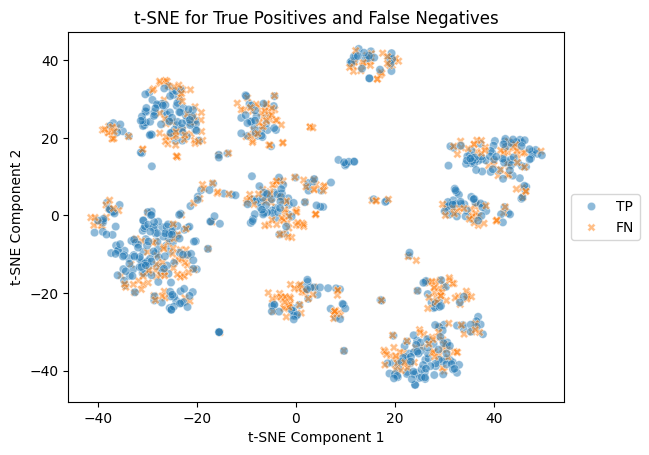

In [15]:
#pca_plot(TPFN_init, title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='error')
tsne_plot(TPFN_init, title='t-SNE for True Positives and False Negatives', alpha = 0.5, tsne_columns =BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, error='error', perplexity=30, learning_rate =200, n_iter= 1000)

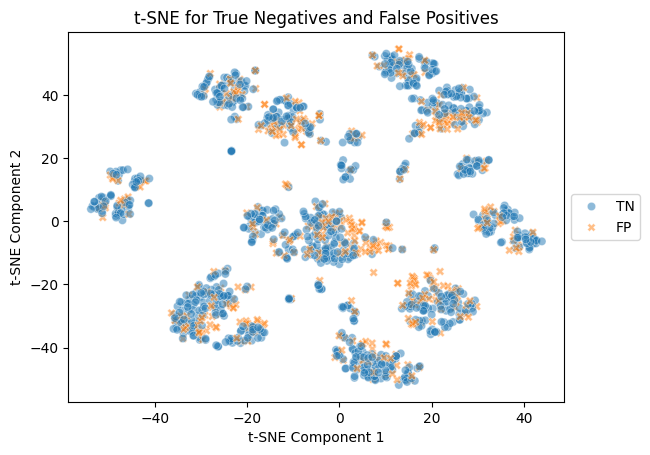

In [16]:
#pca_plot(TNFP_init, error = 'error', title=None, alpha = 0.5, pca_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None)
tsne_plot(TNFP_init, error= 'error', title='t-SNE for True Negatives and False Positives', alpha=0.5, tsne_columns = BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, other_columns=None, perplexity=30, learning_rate =200, n_iter= 1000)

# UTILS FOR CLUSTERING

In [17]:
#get cluster with max error difference
def get_max_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  max_bias = 0 #min possible bias
  max_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue

    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline) #pos function to find highest bias

    if current_bias > max_bias:
      max_bias = current_bias
      max_bias_cluster = cluster_id

    return(max_bias_cluster, max_bias)

#get cluster with min error difference
def get_min_bias_cluster(data, cluster_col= 'clusters', bias_type = 'negative', baseline = 'all', function = get_error_diff):
  min_bias = 1 #max possible bias and look for smt smaller
  min_bias_cluster = -2

  for cluster_id in data[cluster_col].unique():
    if cluster_id == -1: #outliers in dbscan
      continue
    current_bias = function(data, cluster_id, cluster_col, bias_type, baseline)
    if current_bias < min_bias:
      min_bias = current_bias
      min_bias_cluster = cluster_id
  return(min_bias_cluster, min_bias)

#get size of the smallest cluster
def get_min_cluster_size(data, cluster_col = 'new_clusters'):
  min_cluster_size = len(data)
  for i in data['new_clusters'].unique():
    if i == -1: #exclude the -1 clusters as they may present outliers (in dbscan?)
      continue
      size = len(data.loc[data['new_clusters'] == i])
      if size < min_cluster_size: #update if new cluster size is smaller
        min_cluster_size = size
  return(min_cluster_size)

def get_random_cluster(data, cluster_col, min_splittable_cluster_size, previous_cluster, all_cluster_ids):
  for candidate_cluster_id in all_cluster_ids:
    if candidate_cluster_id == -1 or candidate_cluster_id == previous_cluster:
      continue
      print ('This is the random cluster we picked:', candidate_cluster_id)

      candidate_cluster = data.loc[data[cluster_col] == candidate_cluster_id]
      if len(candidate_cluster) >= min_splittable_cluster_size:
        print('it is too small:', len(candidate_cluster))
        continue
      else:
        return candidate_cluster_id

def select_new_cluster(data, cluster_col='clusters', error_column='errors', overall_error_rate=0.5, bias_type='negative', baseline='all'):
    smallest_diff = float('inf')
    selected_cluster = None

    for cluster_id in data[cluster_col].unique():
        if cluster_id == -1: #skip outlier
            continue

        error_diff = get_error_diff(data, cluster_id, cluster_col, bias_type, baseline) #calculate the error_diff for each cluster

        if error_diff is None:
            continue

        abs_diff = abs(overall_error_rate - (get_error_rate(data[data[cluster_col] == cluster_id]))) #get cluster with the smallest absolute difference with the overall error rate (0.5)

        if abs_diff < smallest_diff:
            smallest_diff = abs_diff
            selected_cluster = cluster_id
    return selected_cluster

def exit_clustering(data, msg='', bias_type='', iter=''):
  print('Iteration ', iter, ': ', msg)
  print('Overall error rate: ', get_error_rate(data))
  for c in np.sort(data['clusters'].unique()):
    print('Cluster: ', c, '\tSize: ', len(data.loc[data['clusters'] == c]), '\tError rate: ', get_error_rate(data.loc[data['clusters'] == c]))
  pca_plot(data,'HBAC-DBSCAN on COMPAS - ' + bias_type + ' bias', hue='clusters', s=15, alpha=0.8)
  return data


# K-MEANS CLUSTERING

In [18]:
''''
def hbac_kmeans(data, columns_to_use=[], error='errors', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    if not isinstance(data, pd.DataFrame):
        raise TypeError(f"Expected data to be a DataFrame, but got {type(data)} instead.")

    error_list = []
    initial_bias = 0
    x = 0  # Initialize cluster index

    # Check for error column
    if error in data.columns:
        error_rate = get_error_rate(data, column=error)
        print("Error rate:", error_rate)
    else:
        print(f"Error column '{error}' not found in the dataset. Skipping error-based calculations.")
        error_rate = None

    # Set columns_to_use to all columns if not provided, excluding Error_Type
    if columns_to_use is None:
        columns_to_use = [col for col in data.columns if col != error and col != 'Error_Type']  # All columns except error and Error_Type
    else:
        columns_to_use = [col for col in columns_to_use if col in data.columns]

    # Ensure columns_to_use contains only numeric columns - CHECK if TP is in the data -
    numeric_columns = data[columns_to_use].select_dtypes(include=[np.number]).columns.tolist()
    columns_to_use = numeric_columns  # Update to use only numeric columns

    # Exclude META_COL_VIZ from clustering
    other_columns = [col for col in data.columns if col not in columns_to_use + META_COL_VIZ]

    min_splittable_cluster_size = round(0.05 * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Minimum acceptable size of cluster after split

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check for multiple clusters
            error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate
            data['new_clusters'] = -1  # Reset new clusters

        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

        # Select only numeric columns for K-means
        columns_to_drop_valid = [col for col in columns_to_use if col in candidate_cluster.columns]

        kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[columns_to_drop_valid])

        candidate_cluster['new_clusters'] = kmeans.predict(candidate_cluster[columns_to_drop_valid])

        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])  # Combine new clusters with existing ones

        discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
        print('Discriminative bias:', discr_bias)

        min_cluster_size = get_min_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            print("Adding a new cluster")

            n_cluster = max(data['clusters'])
            data.loc[data['new_clusters'] == 1, 'clusters'] = n_cluster + 1

            if show_plot:
              tsne_plot_new(data, title=None, error=error, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
                #tsne_plot(data, title=None, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5,
                          #tsne_columns=columns_to_use, other_columns=other_columns, error=error)
              plt.show()

            x = select_new_cluster(data, error_column=error)
            initial_bias = discr_bias
        else:
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('Max iterations reached')
    print(error_list)
    return data
'''

'\'\ndef hbac_kmeans(data, columns_to_use=[], error=\'errors\', max_iter=300, show_plot=True):\n    clus_model_kwargs = {\n        "n_clusters": 2,  # Number of clusters to form\n        "init": "k-means++",  # Centroids initialization method\n        "n_init": 10,  # Number of initializations\n        "max_iter": max_iter,  # Maximum iterations for a single run\n    }\n\n    if not isinstance(data, pd.DataFrame):\n        raise TypeError(f"Expected data to be a DataFrame, but got {type(data)} instead.")\n\n    error_list = []\n    initial_bias = 0\n    x = 0  # Initialize cluster index\n\n    # Check for error column\n    if error in data.columns:\n        error_rate = get_error_rate(data, column=error)\n        print("Error rate:", error_rate)\n    else:\n        print(f"Error column \'{error}\' not found in the dataset. Skipping error-based calculations.")\n        error_rate = None\n\n    # Set columns_to_use to all columns if not provided, excluding Error_Type\n    if columns_to_u

In [46]:
round(0.03 * len(TPFN_init))

33

In [48]:
def hbac_kmeans(data, columns_to_use=[], error='errors', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Number of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Number of initializations
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    initial_bias = 0
    x = 0
    error_list = []

    if error in data.columns:
        error_rate = get_error_rate(data, column=error)
        print("Error rate:", error_rate)

    data_to_cluster = data[columns_to_use]

    min_splittable_cluster_size = round(0.05 * len(data))  # Minimum size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Minimum acceptable size of cluster after split

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check for multiple clusters
            error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate
            data['new_clusters'] = -1  # Reset new clusters

        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

    kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[columns_to_use])
    candidate_cluster['new_clusters'] = kmeans.predict(candidate_cluster[columns_to_use])

    data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])  # Combine new clusters with existing ones

    discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
    print('Discriminative bias:', discr_bias)

    min_cluster_size = get_min_cluster_size(data)
    print('Smallest cluster size:', min_cluster_size)

    if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
      print("Adding a new cluster")

      n_cluster = max(data['clusters'])
      data.loc[data['new_clusters'] == 1, 'clusters'] = n_cluster + 1

      if show_plot:
        tsne_plot(data, title=None, error='error', tsne_columns=columns_to_use,
                  other_columns=None, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
        plt.show()

        x = select_new_cluster(data, error_column=error)
        initial_bias = discr_bias
    else:
        x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('Max iterations reached')
    print(error_list)
    return data

In [20]:
'''
# OLD VERSION
def hbac_kmeans(data, columns_to_drop = [], error='FN', max_iter=300, show_plot=True):
    clus_model_kwargs = {
        "n_clusters": 2,  # Nr of clusters to form
        "init": "k-means++",  # Centroids initialization method
        "n_init": 10,  # Nr of times k-means is run with different centroid seeds
        "max_iter": max_iter,  # Maximum iterations for a single run
    }

    x = 0  # Initial cluster number
    initial_bias = 0  # Initial bias value

    error_list = []

    if error in data.columns:
        error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column
        print("error rate:", error_rate)
    else:
        print(f"Error column '{error}' not found in the dataset. Skipping error-based calculations.")
        error_rate = None

    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split
    min_acceptable_cluster_size = round(0.03 * len(data))  # Min acceptable size of cluster after split

    # Iterative clustering loop
    for i in range(1, max_iter):
        if len(data['clusters'].unique()) != 1:  # Check if there are multiple clusters
            if error_rate is not None: #check if there is an error column
                error_list.append(get_error_rate(data, column=error))  # Calculate and store error rate in error_list
            data['new_clusters'] = -1  # update or resets a new column in new clusters with -1

        candidate_cluster = data.loc[data['clusters'] == x]  # Select subset data for the current cluster

        if len(candidate_cluster) < min_splittable_cluster_size:  # Check for size
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())
            continue

        # Select only numeric columns for K-means
        numeric_columns = candidate_cluster.select_dtypes(include=[np.number]).columns

        # Drop META_COL and optionally ERROR_COL based on the provided dataset
        columns_to_drop = META_COL
        if any(col in data.columns for col in ERROR_COL):  # Check if any of the ERROR_COL are present in the dataset
            columns_to_drop += ERROR_COL

        # Ensure that only existing columns are being dropped
        columns_to_drop = [col for col in columns_to_drop if col in numeric_columns]

        kmeans = KMeans(**clus_model_kwargs).fit(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore'))

        candidate_cluster['new_clusters'] = pd.DataFrame(
            kmeans.predict(candidate_cluster[numeric_columns].drop(columns=columns_to_drop, errors='ignore')),
            index=candidate_cluster.index)
        data['new_clusters'] = candidate_cluster['new_clusters'].combine_first(data['new_clusters'])  # Combine new clusters with existing ones

        if error_rate is not None:
            discr_bias = get_error_diff(data, x, 'clusters', bias_type='negative', baseline='all')  # Determine discriminative bias
            print('discriminative bias:', discr_bias)
        else:
            discr_bias = 0

        min_cluster_size = get_min_cluster_size(data)
        print('Smallest cluster size:', min_cluster_size)

        if (discr_bias >= initial_bias) & (min_cluster_size > min_acceptable_cluster_size):
            print("adding a new cluster")
            n_cluster = max(data['clusters'])
            data['clusters'][data['new_clusters'] == 1] = n_cluster + 1

            if show_plot:
                plot_title = f'K-means for {error} Errors' if error_rate is not None else 'K-means Clustering'
                tsne_plot(data, plot_title, perplexity=30, learning_rate=200, n_iter=1000, alpha=0.5)
                plt.show()

            x = select_new_cluster(data, error_column=error if error_rate is not None else None)
            initial_bias = discr_bias

        else:
            x = get_random_cluster(data, 'clusters', min_splittable_cluster_size, x, data['clusters'].unique())

    print('MAX_ITER')
    if error_rate is not None:
        print(error_list)
    return data
'''

'\n# OLD VERSION\ndef hbac_kmeans(data, columns_to_drop = [], error=\'FN\', max_iter=300, show_plot=True):\n    clus_model_kwargs = {\n        "n_clusters": 2,  # Nr of clusters to form\n        "init": "k-means++",  # Centroids initialization method\n        "n_init": 10,  # Nr of times k-means is run with different centroid seeds\n        "max_iter": max_iter,  # Maximum iterations for a single run\n    }\n\n    x = 0  # Initial cluster number\n    initial_bias = 0  # Initial bias value\n\n    error_list = []\n\n    if error in data.columns:\n        error_rate = get_error_rate(data, column=error)  # Calculating mean error rate on the specified error column\n        print("error rate:", error_rate)\n    else:\n        print(f"Error column \'{error}\' not found in the dataset. Skipping error-based calculations.")\n        error_rate = None\n\n    min_splittable_cluster_size = round(0.05 * len(data))  # Min size of cluster to be split\n    min_acceptable_cluster_size = round(0.03 * len

In [21]:
#TPFN_init.info()

# RQ'S


**RQ1: is there a relationshop between shap & risk of error?**

TPFN_init & TNFP_init = *all columns*

SE = shap and error columns

FE = all columns except shap (selma)


--------------------------------------------------
**RQ2: does shap help in finding disc clusters?**

FS = all columns except error

S = only SHAP_COL

F = only BASIC_COL


# SHAP & ERROR & BASIC COL

In [22]:
#TPFN_init.iloc[3]

***Clustering all columns TP FN DATA***

In [52]:
clustered_shap_err_basic_TPFN = hbac_kmeans(data=TPFN_init, columns_to_use=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=1000, show_plot=True)
plt.show()

Error rate: 0.4421148587055606
Discriminative bias: -0.005794103988579491
Smallest cluster size: 1097
Max iterations reached
[0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.442114858705

In [54]:
c= get_max_bias_cluster(clustered_shap_err_basic_TPFN)

Mean_error_rate_TPFN = get_error_rate(clustered_shap_err_basic_TPFN)

print ('Mean error rate of full TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")


Mean error rate of full TPFN data set: 0.4421148587055606
 cluster (-2, 0) has the highest discrimination bias for TPFN data


***TPFN ALL COLUMNS ANOVA***

In [53]:
'''SHAP, ERROR & BASIC COLUMNS FOR TPFN ANOVA'''
#check per identified cluster whether the errors significantly differ
groupstpfn = clustered_shap_err_basic_TPFN.groupby('clusters')['errors'].apply(list)
anovatpfn = [np.array(groupstpfn) for groupstpfn in groupstpfn]

f_stat, p_val = f_oneway(*anovatpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


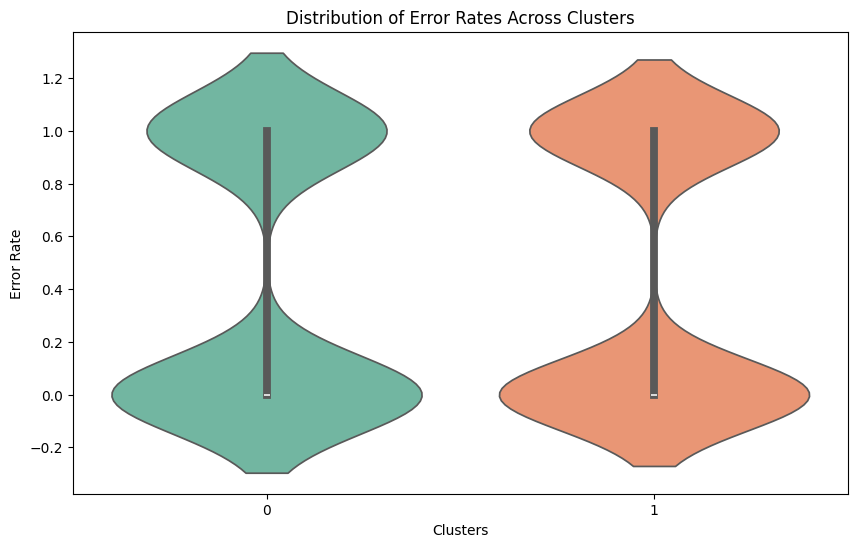

In [55]:
# Prepare the data by melting the dataframe
melted_data = clustered_shap_err_basic_TPFN.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

***Clustering all columns TN FP DATA***

In [56]:
clustered_shap_err_basic_TNFP = hbac_kmeans(data=TNFP_init, columns_to_use=BASIC_COL_scaled + DUMMY_COL_scaled + ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.3104434907010014
Discriminative bias: -0.004119380029064645
Smallest cluster size: 1398
Max iterations reached
[0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.310443490701

In [57]:
c= get_max_bias_cluster(clustered_shap_err_basic_TNFP)

Mean_error_rate_TNFP = get_error_rate(clustered_shap_err_basic_TNFP)

print ('Mean error rate of full TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for TNFP data")


Mean error rate of full TNFP data set: 0.3104434907010014
 cluster (-2, 0) has the highest discrimination bias for TNFP data


***TNFP ALL COLUMNS ANOVA***

In [58]:
'''SHAP, ERROR & BASIC COLUMNS FOR TNFP ANOVA'''
groupstnfp = clustered_shap_err_basic_TNFP.groupby('clusters')['FP'].apply(list)
anovatnfp = [np.array(groupstnfp) for groupstnfp in groupstnfp]

f_stat, p_val = f_oneway(*anovatnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.0627771951871686
p-value: 0.8021959917743023
there are no statistically significant differences between the clusters


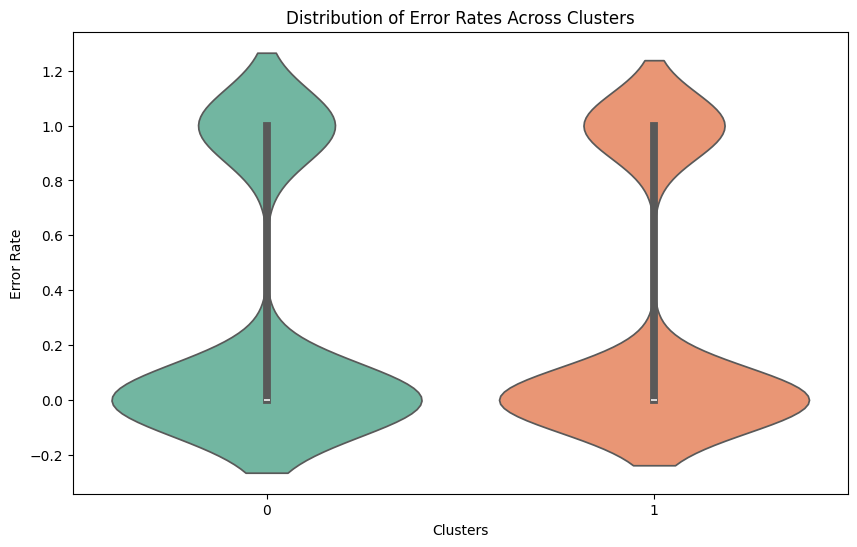

In [59]:
# Prepare the data by melting the dataframe
melted_data = clustered_shap_err_basic_TNFP.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

# SHAP & ERROR COLUMNS NO BASIC FEATURES

In [40]:
'''SE: SHAP_COL and ERROR_COL no BASIC_COL '''
columns = ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled + META_COL + META_COL_VIZ
SE_TPFN = TPFN_init[columns]
SE_TNFP = TNFP_init[columns] #scaled

#SE_TPFN.iloc[3]
SE_TNFP.iloc[3]

errors_scaled                        1.327722
TP_scaled                           -0.573496
TN_scaled                           -0.800528
FN_scaled                           -0.492612
FP_scaled                            2.236068
Shap_age_scaled                     -0.279174
Shap_decile_score_scaled            -0.800271
Shap_priors_count_scaled            -0.531185
Shap_sex_Female_scaled               0.273211
Shap_race_African-American_scaled    0.543617
Shap_race_Asian_scaled              -0.054634
Shap_race_Caucasian_scaled           1.949653
Shap_race_Hispanic_scaled            0.065513
Shap_race_Native American_scaled     0.042717
Shap_race_Other_scaled               0.178203
clusters                                    0
new_clusters                                0
Error_Type                                 TN
Name: 5, dtype: object

***SHAP AND ERROR KMEANS ON TPFN***

In [62]:
'''KMEANS SHAP & ERROR COLUMNS FOR TPFN '''
Clustered_shap_err_TPFN = hbac_kmeans(data=TPFN_init, columns_to_use=ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.4421148587055606
Discriminative bias: -0.005794103988579491
Smallest cluster size: 1097
Max iterations reached
[0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.4421148587055606, 0.442114858705

In [71]:
c= get_max_bias_cluster(Clustered_shap_err_TPFN)

Mean_error_rate_SE_TPFN = get_error_rate(Clustered_shap_err_TPFN, 'errors')

print ('Mean error rate of SE_TPFN data set:', Mean_error_rate_SE_TPFN)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

Mean error rate of SE_TPFN data set: 0.4421148587055606
 cluster (-2, 0) has the highest discrimination bias for TPFN data


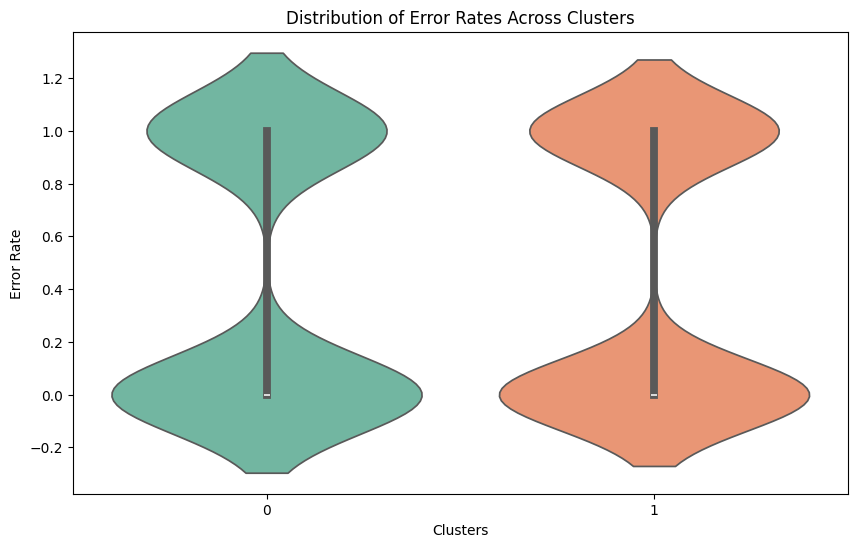

In [67]:
melted_data = Clustered_shap_err_TPFN.melt(id_vars=['clusters'], value_vars=['errors'], var_name='Metric', value_name='Error Rate')

# Create the violin plot
plt.figure(figsize=(10, 6))
sns.violinplot(x='clusters', y='Error Rate', data=melted_data, inner='box', scale='width', palette='Set2')
plt.title('Distribution of Error Rates Across Clusters')
plt.xlabel('Clusters')
plt.ylabel('Error Rate')
plt.show()

***SHAP AND ERROR ANOVA ON TPFN***

In [70]:
'''SHAP & ERROR COLUMNS FOR TPFN ANOVA'''
groupsSE_tpfn = Clustered_shap_err_TPFN.groupby('clusters')['errors'].apply(list)
anovaSE_tpfn = [np.array(groupsSE_tpfn) for groupsSE_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


***SHAP AND ERROR KMEANS ON TNFP***

In [68]:
'''KMEANS SHAP & ERROR COLUMNS FOR TNFP'''
Clustered_shap_err_TNFP = hbac_kmeans(data = TNFP_init, columns_to_use=ERROR_COL_scaled + SHAP_BASIC_scaled + SHAP_DUMMY_scaled, error='errors', max_iter=300, show_plot=True)
plt.show()

Error rate: 0.3104434907010014
Discriminative bias: -0.004119380029064645
Smallest cluster size: 1398
Max iterations reached
[0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.3104434907010014, 0.310443490701

In [73]:
c= get_max_bias_cluster(Clustered_shap_err_TNFP)

Mean_error_rate_SE_TNFP = get_error_rate(Clustered_shap_err_TNFP, 'errors')

print ('Mean error rate of SE_TPFN data set:', Mean_error_rate_SE_TNFP)

print (f" cluster {c} has the highest discrimination bias for TPFN data")

Mean error rate of SE_TPFN data set: 0.3104434907010014
 cluster (-2, 0) has the highest discrimination bias for TPFN data


***SHAP AND ERROR ANOVA ON TNFP***

In [74]:
'''SHAP & ERROR COLUMNS FOR TNFP ANOVA'''
groupsSE_tnfp = Clustered_shap_err_TNFP.groupby('clusters')['errors'].apply(list)
anovaSE_tnfp = [np.array(groupsSE_tpfn) for groupsSE_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaSE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

F-statistic: 0.09390631957908324
p-value: 0.7593268629080284
there are no statistically significant differences between the clusters


In [75]:
Clustered_shap_err_TNFP.iloc[3]

age                                      40.0
decile_score                              1.0
priors_count                              0.0
sex_Female                                0.0
race_African-American                     1.0
race_Asian                                0.0
race_Caucasian                            0.0
race_Hispanic                             0.0
race_Native American                      0.0
race_Other                                0.0
age_scaled                           0.224279
decile_score_scaled                 -0.994168
priors_count_scaled                 -0.640735
sex_Female_scaled                   -0.532679
race_African-American_scaled         1.085159
race_Asian_scaled                   -0.053567
race_Caucasian_scaled               -0.762527
race_Hispanic_scaled                 -0.34018
race_Native American_scaled         -0.065653
race_Other_scaled                   -0.257607
errors                                    0.0
TP                                

# ERROR AND BASIC COLUMNS NO SHAP (SELMA)

In [ ]:
TPFN_init.iloc[3]

In [ ]:
'''FE: FEATURES AND ERROR NO SHAP (Selma) '''
columns_to_drop = SHAP_COL_Basic_scaled + SHAP_COL_Dummy_scaled

FE_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FE_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FE_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & ERROR K-MEANS ON TPFN***

In [ ]:
'''BASIC & ERROR K-MEANS ON TPFN'''
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TPFN_init, columns_to_drop = ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TPFN)

Mean_error_rate_FE_TPFN = get_error_rate(FE_TPFN)

print ('Mean error rate of FE_TPFN data set:', Mean_error_rate_TPFN)

print (f" cluster {c} has the highest discrimination bias for FE_TPFN data")

In [ ]:
FE_TPFN.iloc[3]

***BASIC & ERROR ANOVA ON TPFN***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TPFN ANOVA'''
groupsFE_tpfn = FE_TPFN.groupby('clusters')['FN'].apply(list)
anovaFE_tpfn = [np.array(groupsFE_tpfn) for groupsFE_tpfn in groupsFE_tpfn]

f_stat, p_val = f_oneway(*anovaFE_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & ERROR K-MEANS ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP'''
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=True, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop= ['SHAP_COL_Basic_scaled', 'SHAP_COL_Dummy_scaled'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
c= get_max_bias_cluster(FE_TNFP)

Mean_error_rate_FE_TNFP = get_error_rate(FE_TNFP)

print ('Mean error rate of FE_TNFP data set:', Mean_error_rate_TNFP)

print (f" cluster {c} has the highest discrimination bias for FE_TNFP data")

***BASIC & ERROR ANOVA ON TNFP***

In [ ]:
'''BASIC & ERROR COLUMNS FOR TNFP ANOVA'''
groupsFE_tnfp = FE_TNFP.groupby('clusters')['FP'].apply(list)
anovaFE_tnfp = [np.array(groupsFE_tnfp) for groupsFE_tnfp in groupsFE_tnfp]

f_stat, p_val = f_oneway(*anovaFE_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# SHAP & BASIC COLUMNS NO ERROR

In [ ]:
#TPFN_init.iloc[3]

In [ ]:
'''FS: FEATURES AND SHAP NO ERROR '''
columns_to_drop = ERROR_COL

FS_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
FS_TNFP = TNFP_init.drop(columns_to_drop, axis=1) #scaled

FS_TPFN = initialize_dataset(FS_TPFN, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)
FS_TNFP = initialize_dataset(FS_TNFP, unscaled=True, meta_col=True, with_error_col= False, with_classes=True)

FS_TPFN.iloc[3]
#FE_TNFP.iloc[3]

***BASIC & SHAP KMEANS ON TPFN***

In [ ]:
#Run it on TPFN_init and drop columns ERROR as you go through loop in clustering otherwise it doesn't work
TPFN_init = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TPFN_init, columns_to_drop= ['ERROR_COL'], error='FN', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tpfn = FS_TPFN.groupby('clusters')['Error_Type'].apply(list)
anovaFS_tpfn = [np.array(groupsFS_tpfn) for groupsFS_tpfn in groupsSE_tpfn]

f_stat, p_val = f_oneway(*anovaFS_tpfn)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

***BASIC & SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data=TNFP_init, columns_to_drop=['ERROR_COL', 'META_COL'], error='FP', max_iter=300, show_plot=True)

***BASIC & SHAP ANOVA ON TNFP***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsFS_tnfp = FS_TNFP.groupby('clusters')['FP'].apply(list)
anovaFS_tnfp = [np.array(groupsFS_tnfp) for groupsFS_tnfp in groupsSE_tnfp]

f_stat, p_val = f_oneway(*anovaFS_tnfp)

print('F-statistic:', f_stat)
print('p-value:', p_val)

alpha = 0.05
if p_val < alpha:
  print("there are statistically significant differences between the clusters.")
else:
  print("there are no statistically significant differences between the clusters")

# ONLY SHAP COL

In [ ]:
columns_to_drop = BASIC_COL_unscaled + DUMMY_unscaled + ERROR_COL
S_TPFN = TPFN_init.drop(columns_to_drop, axis=1) #scaled
S_TNFP = TNFP_init.drop(columns_to_drop, axis=1)

S_TPFN.iloc[23]

***SHAP KMEANS ON TPFN***

In [ ]:
TPFN_init_S = initialize_dataset(TPFN_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
#pass original dataset and not SE_TPFN otherwise the clustering doesn't work
hbac_kmeans(data = TPFN_init_S, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FN', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
MAXnegbias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

MINnegbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

MAXposbias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

MINposbias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TPFN***

In [ ]:
#kept error_type in otherwise anova doesnt work
groupsS_tpfn = TPFN_init_S.groupby('clusters')['FN'].apply(list)

# Check the number of groups
print("Number of groups:", len(groupsS_tpfn))

anovaS_tpfn = [np.array(groupsS_tpfn) for groupsS_tpfn in groupsS_tpfn]

# Proceed with ANOVA only if there are at least two groups
if len(anovaS_tpfn) >= 2:
    f_stat, p_val = f_oneway(*anovaS_tpfn)

    print('F-statistic:', f_stat)
    print('p-value:', p_val)

    alpha = 0.05
    if p_val < alpha:
        print("there are statistically significant differences between the clusters.")
    else:
        print("there are no statistically significant differences between the clusters")
else:
    print("ANOVA cannot be performed with less than two groups.")

***SHAP KMEANS ON TNFP***

In [ ]:
TNFP_init = initialize_dataset(TNFP_unscaled, unscaled=True, meta_col=True, with_error_col=False, with_classes=True)
hbac_kmeans(data = TNFP_init, columns_to_drop = ['BASIC_COL_unscaled', 'DUMMY_unscaled', 'ERROR_COL'], error= 'FP', max_iter = 300, show_plot= True)
plt.show()

In [ ]:
max_neg_bias = get_max_bias_cluster(TPFN_init_S, bias_type='negative', baseline='all')
#highest_biased_cluster = TPFN_init_S[TPFN_init_S['clusters'] == c]

print ('cluster ID with the max negative bias is (1st score) against a minimum possible bias of (2nd score)', (max_neg_bias))

min_neg_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'negative', baseline = 'all')
print ('cluster ID with the min negative bias is (1st score) against a maximum possible  ', (min_neg_bias))

max_pos_bias = get_max_bias_cluster(TPFN_init_S, bias_type='positive', baseline='all')
print ('cluster ID with the max positive bias is (1st score) against a minimum possible bias of (2nd score)', (max_pos_bias))

min_pos_bias = get_min_bias_cluster(TPFN_init_S, bias_type = 'positive', baseline = 'all')
print ('cluster ID with the min positive bias is (1st score) against a maximum possible  ', (min_pos_bias))



***SHAP ANOVA ON TNFP***

# ONLY BASIC COL

***BASIC KMEANS ON TPFN***

***BASIC ANOVA ON TPFN***

***BASIC KMEANS ON TNFP***

***BASIC ANOVA ON TNFP***